In [1]:
import os, sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline

leaspy_path = '/network/lustre/dtlake01/aramis/users/juliette.ortholand/leaspy/' #TO CHANGE

sys.path.append(leaspy_path)

from leaspy import Leaspy, IndividualParameters, AlgorithmSettings, Data

# Load 

In [2]:
df_normed = pd.read_csv("simulated_data-noisy_SCOPA.csv")
df_normed = df_normed.astype({'ID':'string'})
df_normed.set_index(['ID', 'TIME'], inplace=True)
print(len(df_normed))
df_normed.head()

1988


MDS1_total  MDS2_total  MDS3_off_total  SCOPA_total  \
ID     TIME                                                             
GS-001 62.289333    0.004518    0.068390        0.166300     0.000000   
       62.789333    0.089316    0.126355        0.118627     0.079459   
       63.289333    0.037611    0.050422        0.220779     0.000000   
       64.289330    0.112131    0.000000        0.335756     0.618889   
       64.789330    0.080184    0.091392        0.224638     0.000000   

                  MOCA_total  REM_total  PUTAMEN_R  PUTAMEN_L  CAUDATE_R  \
ID     TIME                                                                
GS-001 62.289333    0.107169   0.078704   0.599264   0.587410   0.281644   
       62.789333    0.156544   0.374873   0.516092   0.723004   0.107746   
       63.289333    0.000000   0.194420   0.579225   0.791977   0.280972   
       64.289330    0.004959   0.237782   0.662681   0.744099   0.201657   
       64.789330    0.048896   0.159916   0.697169   0.720996   0.175301   

                  CAUDATE_L  
ID     TIME                  
GS-001 62.289333   0.181655  
       62.789333   0.410228  
       63.289333   0.269620  
       64.289330   0.345901  
       64.789330   0.382367

# Unnormalised

The different scores are normalised for the moment. The first step is to put them back to their real format :
* __MDS1_total__ : monotone increasing score from 0 to 52,
* __MDS2_total__ : monotone increasing score from 0 to 52,
* __MDS3_off_total__ : monotone increasing score from 0 to 132,
* __SCOPA_total__ : monotone increasing score from 0 to 72,
* __MOCA_total__ : monotone decreasing score from 30 to 0,
* __REM_total__ : ?????
* __PUTAMEN_R__ : monotone increasing score with limit normal 0.03 and limit abnormal 3.76,
* __PUTAMEN_L__ : monotone increasing score with limit normal 0.01 and limit abnormal 4.27,
* __CAUDATE_R__ : monotone increasing score with limit normal 0.06 and limit abnormal 4.96,
* __CAUDATE_L__ : monotone increasing score with limit normal 0.015 and limit abnormal 4.75.

In [3]:
df_true_values = pd.DataFrame(index = df_normed.index)
df_true_values["MDS1_total"] = 52*df_normed["MDS1_total"]
df_true_values["MDS2_total"] = 52*df_normed["MDS2_total"]
df_true_values["MDS3_off_total"] = 132*df_normed["MDS3_off_total"]
df_true_values["SCOPA_total"] = 72*df_normed["SCOPA_total"]

df_true_values["MOCA_total"] = (1-df_normed["MOCA_total"])*30

#df_true_values["REM_total"] = df_normed["REM_total"]

df_true_values["PUTAMEN_R"] = (0.03 + df_normed["PUTAMEN_R"])/(3.76 - 0.03)
df_true_values["PUTAMEN_L"] = (0.01 + df_normed["PUTAMEN_L"])/(4.27 - 0.01)
df_true_values["CAUDATE_R"] = (0.06 + df_normed["CAUDATE_R"])/(4.96 - 0.06)
df_true_values["CAUDATE_L"] = (0.015 + df_normed["CAUDATE_L"])/(4.75 - 0.015)

# Add NaN and unknowed value -9

une colonne avec les 100 1ers patients qui n'ont que des NAN
données d'imagerie pas dispo sur les même visites que les scores cliniques
ex pour les scores clinique: MDS dispo à toutes les visites sauf visites d'imagerie, MOCA dispo une fois sur deux, et un autre score dispo une fois sur trois ou une fois sur 4.
uen feature avec des NAN -9

In [4]:
for i in range(len(df_true_values.index)) :
    if i%3 == 0 :
        df_true_values.at[df_true_values.index[i],"MDS1_total"] = np.nan
        
    if i%9 == 0 :
        df_true_values.at[df_true_values.index[i],"MDS3_off_total"] = -9
        

# Add not monotone feature

Let's now set that REM is a new feature named "AGD_total". This new score will be set to vary between 0 and 0.5 but is not monotonus with the development of Parkinson deasise.

<AxesSubplot:>

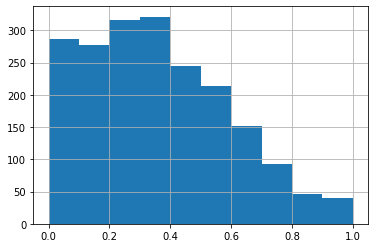

In [5]:
df_normed["REM_total"].hist()

In [6]:
df_true_values["AGD_total"] = df_normed["REM_total"]

for i in range(len(df_true_values.index)) :
    if df_true_values["AGD_total"].iloc[i] >0.5 :
        df_true_values.at[df_true_values.index[i],"AGD_total"] = 1 - df_true_values["AGD_total"].iloc[i]

How to print a feature that is not monotonous????

# Create patients with one visit

There is 200 different patients, with in average XX visits. We select patients : GS-050, GS-100, GS-150 and GS-200 and we set there number of visit to one (we keep only the first one). 

In [7]:
list_id = ['GS-050', 'GS-100', 'GS-150', 'GS-200']
list_to_drop = []
for id_ in list_id :
    for i in range(2, len(df_true_values.loc[id_].index)):
        list_to_drop.append((id_, df_true_values.loc[id_].index[i]))
df_visit = df_true_values.drop(list_to_drop)

# Separate last visit for prediction

In [8]:
learn = []
pred = []
for df in df_visit.groupby("ID"):
    learn.append(df[1].iloc[:-1])
    pred.append(df[1].iloc[-1])

In [9]:
df_learn = pd.concat(learn)
df_pred = pd.concat(pred, axis = 1).T
df_pred.index.names = ['ID','TIME']

# Save

In [10]:
df_learn.to_csv("learn_leaspy2.csv")
df_pred.to_csv("pred_leaspy2.csv")

# Create cofactor

In [11]:
col = ["MDS3_off_total", "MDS2_total"]
data = Data.from_dataframe(df_normed[col]) 

In [12]:
##SET PARAMETERS
leaspy_model = "logistic" #'univariate'
nb_source = 2
algo_settings = AlgorithmSettings('mcmc_saem', 
                                  n_iter=3000,           # n_iter defines the number of iterations
                                  progress_bar=True)     # To display a nice progression bar during calibration

##FIT
leaspy = Leaspy(leaspy_model)
leaspy.model.load_hyperparameters({'source_dimension': nb_source})
leaspy.fit(data, algorithm_settings=algo_settings)

|##################################################|   3000/3000 iterations
The standard deviation of the noise at the end of the calibration is:
0.0598

Calibration took: 44s


In [15]:
##SET PARAMETERS
settings_personalization = AlgorithmSettings('scipy_minimize', progress_bar=True)

##PREDICTIONS
ip = leaspy.personalize(data, settings_personalization)

|##################################################|   200/200 subjects
The standard deviation of the noise at the end of the personalization is:
0.0556

Personalization scipy_minimize took: 52s


In [17]:
# —— Convert individual parameters to dataframe
df_ip = ip.to_dataframe()

In [18]:
df_cof = pd.DataFrame(0, columns = ['MUTATION'],index = df_ip.index)
for i in df_cof.index :
    if df_ip["tau"].loc[i]>70 and df_ip["xi"].loc[i]<0.5:
        df_cof.at[i,'MUTATION'] = 1
    elif df_ip["tau"].loc[i]>65 and df_ip["xi"].loc[i]<0.25:
        rd = random.randint(1, 3)
        if rd != 3 :
            df_cof.at[i,'MUTATION'] = 1
    elif df_ip["tau"].loc[i]>60 and df_ip["xi"].loc[i]<0:
        rd = random.randint(1, 3)
        if rd == 3 :
            df_cof.at[i,'MUTATION'] = 1

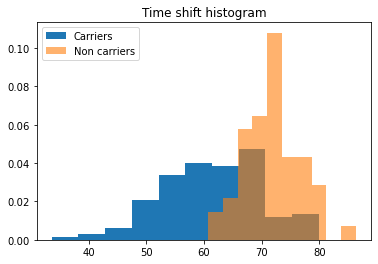

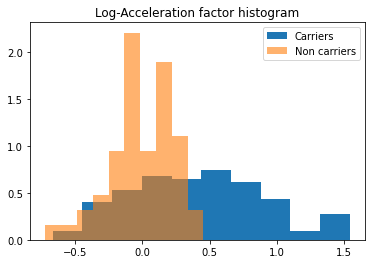

In [19]:
# —— Convert individual parameters to dataframe
df_ip = ip.to_dataframe()

# —— Merge with cofactors
df_ip = df_ip.join(df_cof)

# —— Separate the individual parameters with respect to the cofactor
carriers = df_ip[df_ip['MUTATION'] == 0.]
non_carriers = df_ip[df_ip['MUTATION'] == 1.]

# —— Plot the time shifts in carriers and non-carriers
plt.title('Time shift histogram')
plt.hist(carriers['tau'], density=True, label='Carriers')
plt.hist(non_carriers['tau'], density=True, alpha=0.6, label='Non carriers')
plt.legend()
plt.show()


# —— Plot the acceleration factor in carriers and non-carriers
plt.title('Log-Acceleration factor histogram')
plt.hist(carriers['xi'], density=True, label='Carriers')
plt.hist(non_carriers['xi'], density=True, alpha=0.6, label='Non carriers')
plt.legend()
plt.show()

In [20]:
from scipy import stats

# —— Student t-test (under the asumption of a gaussian distribution only)
print(stats.ttest_ind(carriers['tau'], non_carriers['tau']))
print(stats.ttest_ind(carriers['xi'], non_carriers['xi']))

# —— Mann-withney t-test
print(stats.mannwhitneyu(carriers['tau'], non_carriers['tau']))
print(stats.mannwhitneyu(carriers['xi'], non_carriers['xi']))

Ttest_indResult(statistic=-8.471553339560197, pvalue=5.4540291928829294e-15)
Ttest_indResult(statistic=5.89946336208136, pvalue=1.5560283079644453e-08)
MannwhitneyuResult(statistic=1118.0, pvalue=3.932040626084918e-15)
MannwhitneyuResult(statistic=1940.0, pvalue=1.817158655395327e-08)


In [21]:
df_cof.to_csv("cof_leaspy2.csv")

# Add futur visit

In [ ]:
#df_fut = df_visit.copy().reset_index()
#df_fut["NEXT_TIME"] = df_fut["TIME"]+0.5
#df_fut = df_fut.rename(columns={"TIME": "PAST_TIME","NEXT_TIME": "TIME"})
#df_visit["NEXT_MDS3"] = df_visit["MDS3_off_total"]
#df_fut.set_index(['ID', 'TIME'], inplace=True)
#df_pop = pd.merge(df_fut,df_visit[["NEXT_MDS3"]], on=['ID','TIME'])
#df_pop = df_pop.reset_index()
#df_pop = df_pop.rename(columns={"PAST_TIME": "TIME","TIME":"NEXT_TIME"})
#df_pop.set_index(['ID', 'TIME'], inplace=True)
#df_pop.head()